## Clustering Demographics 

In [3]:
######################## LOAD IN FILES #############################
import os
import pandas as pd
import sys
import importlib
import numpy as np
import pandas as pd
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform


# Get the absolute path of the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define data directory
brighten_dir = os.path.join(project_root, 'BRIGHTEN_data')

# Add project root to sys.path for script usage
sys.path.append(project_root)

# Import and reload (optional) custom scripts
from scripts import preprocessing as pre
from scripts import visualization as vis
from scripts import clustering as cl
importlib.reload(pre)
importlib.reload(vis)
importlib.reload(cl)


################ DEFINE column variables from data ###################
from scripts.variables import id_columns, daily_cols_v1, daily_v2_common, df_names
from scripts.variables import phq2_cols, phq9_cols, weekly_cols, passive_cols, survey_cols

print(df_names)

['v1_day', 'v2_day', 'v1_week', 'v2_week']


/opt/anaconda3/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
mhs = pd.read_csv(os.path.join(brighten_dir,'Mental Health Services.csv'))
mhs




NameError: name 'pd' is not defined

In [38]:
# Read in DFs and create demo_df

dfs = {}
dfs['phq9_baseline'] = pd.read_csv(os.path.join(brighten_dir,'PHQ-9 - Baseline.csv'))
dfs['demographics'] = pd.read_csv(os.path.join(brighten_dir,'Baseline Demographics.csv'))
dfs['mania'] = pd.read_csv(os.path.join(brighten_dir,'IMPACT Mania and Psychosis Screening.csv'))
dfs['alc'] = pd.read_csv(os.path.join(brighten_dir,'Alcohol.csv'))
dfs['gad'] = pd.read_csv(os.path.join(brighten_dir,'GAD - Anxiety.csv'))
dfs['mhs'] = pd.read_csv(os.path.join(brighten_dir,'Mental Health Services.csv'))

id_key = pd.read_csv(os.path.join(brighten_dir, 'id_key.csv'))

for name, df in dfs.items():
    df = pd.merge(df, id_key[['num_id','participant_id']], how='outer', on='participant_id')
    df = df.drop(['participant_id'], axis=1)  # drop to keep anonymity

    if 'dt' in df.columns:
        df = df.drop(['dt'], axis=1)
    if 'phq9_1_base' in df.columns:
        df['phq9_sum_base'] = df['phq9_1_base'].fillna(0).astype(int) + df['phq9_2_base'].fillna(0).astype(int) +df['phq9_3_base'].fillna(0).astype(int) +df['phq9_4_base'].fillna(0).astype(int) +df['phq9_5_base'].fillna(0).astype(int) +df['phq9_6_base'].fillna(0).astype(int) +df['phq9_7_base'].fillna(0).astype(int) +df['phq9_8_base'].fillna(0).astype(int) +df['phq9_9_base'].fillna(0).astype(int)
    if 'dt_response' in df.columns:
        df = df.drop(['dt_response','ROW_ID','ROW_VERSION'], axis=1)
    if 'dt_passive' in df.columns:
        df = df.drop(['dt_passive','ROW_ID','ROW_VERSION'], axis=1)
    if 'time_in' in df.columns:
        df = df.drop(['time_in','time_out', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'baselinePHQ9date' in df.columns:
        df = df.drop(['baselinePHQ9date', 'ROW_ID','ROW_VERSION'], axis=1)
    if 'study' in df.columns: # drop because duplicated across tables
        df = df.drop(['study'], axis=1)
    if 'cohort' in df.columns: # drop because duplicated across tables 
        df = df.drop(['cohort'], axis=1)
    if 'day' in df.columns: # drop because not needed
        df = df.drop(['day'], axis=1)
    if 'week' in df.columns:
        df = df.drop(['week'], axis=1)  # drop because not needed
    if 'heard_about_us'  in df.columns:
        df = df.drop(['heard_about_us'], axis=1)  # drop because not needed
    if 'device' in df.columns:
        df = df.drop(['device'], axis=1)  # drop because not needed
    if 'startdate' in df.columns:
        df = df.drop(['startdate'], axis=1)  # drop because not needed
    if 'study_arm' in df.columns:
        df = df.drop(['study_arm'], axis=1)  # drop because not needed
    if 'sum_phq9' in df.columns:
        df.rename(columns={'sum_phq9': 'phq9_sum'}, inplace=True)
    ## Sum aggregate variables 
    if 'mhs_1' in df.columns:
        df['mhs_sum'] = df['mhs_1'].fillna(0).astype(int) + df['mhs_2'].fillna(0).astype(int) + df['mhs_3'].fillna(0).astype(int) + df['mhs_4'].fillna(0).astype(int) + df['mhs_5'].fillna(0).astype(int)
    if 'screen_2' in df.columns:
        df['bipolar'] = df['screen_2'].fillna(0).astype(int) + df['screen_3'].fillna(0).astype(int)
        df['scz'] = df['screen_1'].fillna(0).astype(int) + df['screen_4'].fillna(0).astype(int)
    
    # Update the dfs dictionary with the modified DataFrame
    dfs[name] = df

    print(name, df.shape)






phq9_baseline (2112, 11)
demographics (2259, 9)
mania (2119, 7)
alc (2115, 5)
gad (2113, 10)
mhs (3489, 7)


In [46]:
### Create merge df 

print(name)
base_df = pd.read_csv(os.path.join(brighten_dir,'alldays_df.csv'))
merge_df = base_df[['num_id']]
print(merge_df.shape)

for survey_name, survey_df in dfs.items():
    # Check if 'num_id' exists in the current df
    if 'num_id' in survey_df.columns:
        print(survey_name, survey_df.shape)
        merge_df = pd.merge(merge_df, survey_df, on=['num_id'], how='left')
        print(f'Merged in {survey_name}')
        for sub in merge_df['num_id'].unique():
            sub_df = merge_df[merge_df['num_id']==sub]
            sub_df = sub_df.bfill().ffill()
        merge_df = merge_df.drop_duplicates()
        print(survey_name, merge_df.shape, merge_df.columns)

        
    else:
        print(f"Skipping {survey_name}, 'num_id' column is missing.")



# Save merge_df to csv
merge_df = merge_df.sort_values(by=['num_id'])
merge_df.to_csv(os.path.join(brighten_dir, f'demographics.csv'), index=False)
print(f'Saved demo_df to demographics.csv')


v2_week
(82474, 1)
phq9_baseline (2112, 11)
Merged in phq9_baseline


/var/folders/fl/b24z_8kn4490x_bl0njv6fg00000gn/T/ipykernel_56465/2500155930.py:4: DtypeWarning: Columns (13,18,62,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  base_df = pd.read_csv(os.path.join(brighten_dir,'alldays_df.csv'))


phq9_baseline (2111, 11) Index(['num_id', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base',
       'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base',
       'phq9_9_base', 'phq9_sum_base'],
      dtype='object')
demographics (2259, 9)
Merged in demographics
demographics (2111, 19) Index(['num_id', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base',
       'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base',
       'phq9_9_base', 'phq9_sum_base', 'gender', 'education', 'working',
       'income_satisfaction', 'income_lastyear', 'marital_status', 'race',
       'age'],
      dtype='object')
mania (2119, 7)
Merged in mania
mania (2111, 25) Index(['num_id', 'phq9_1_base', 'phq9_2_base', 'phq9_3_base', 'phq9_4_base',
       'phq9_5_base', 'phq9_6_base', 'phq9_7_base', 'phq9_8_base',
       'phq9_9_base', 'phq9_sum_base', 'gender', 'education', 'working',
       'income_satisfaction', 'income_lastyear', 'marital_status', 'race',
       'age', 'screen_1', 'sc

In [47]:
### Create merge df 
df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))


### Turn categorical variables to numerical variables
# Convert to category type
# Apply LabelEncoder to each categorical column
label_encoders = {}  # Store encoders for later use
cols = ['gender','education','working','income_satisfaction','income_lastyear','marital_status','race','age']
transform_cols = [col for col in df.columns if col in cols]
cols_missing = [col for col in cols if col not in df.columns]
if len(cols_missing)>0:
    print(f'Cols not in demographics', cols_missing)
for col in transform_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Transform to numeric IDs
    label_encoders[col] = le  # Save encoder for inverse transform if needed


'''
Currently, keep these
    "alc_1", "alc_2", "alc_3", "gad7_1", "gad7_2", "gad7_3", "gad7_4", "gad7_5", "gad7_6", "gad7_7", "gad7_8",
    "mhs_1", "mhs_2", "mhs_3", "mhs_4", "mhs_5","phq9_1_base", "phq9_2_base", "phq9_3_base", "phq9_4_base", "phq9_5_base", 
    "phq9_6_base", "phq9_7_base", "phq9_8_base", "phq9_9_base"])
'''


# Add binary variable for if subject passes clinical cutoff for anxiety, depression, scz or bp
df['bin_clin'] = (
    (df['bipolar'] > 0) |  # Check if bipolar column is 1
    (df['scz'] > 0) | # Check if scz column is 1
    (df['gad7_sum'] > 10) |  # Check if gad_sum > 10
    (df['phq9_sum_base'] > 15)   # Check if phq9_sum > 15
).astype(int)  # Convert boolean values to 0/1



df.to_csv(os.path.join(brighten_dir, f'demographics.csv'))
print(f'Saved df to demographics.csv')
print(df.shape)

Saved df to demographics.csv
(2555, 45)


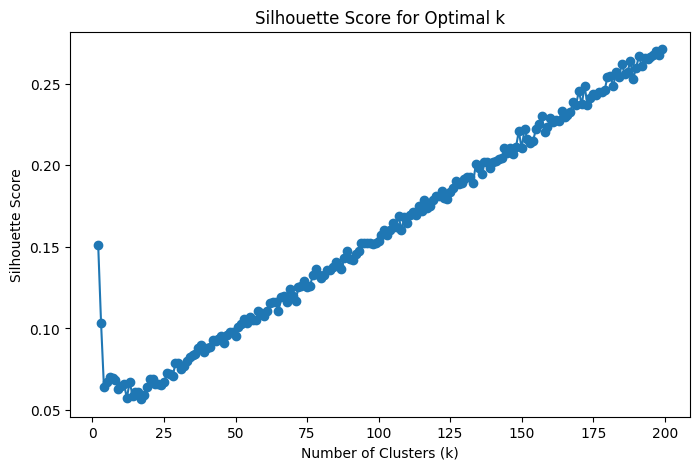

In [ ]:
demo_df = pd.read_csv(os.path.join(brighten_dir, f'demographics.csv'))
demo_df = demo_df.loc[:, ~demo_df.columns.str.contains('^Unnamed')]

silhouette_scores = []

for k in range(2, 200):  # Silhouette score works for k ≥ 2
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(demo_df)
    silhouette_scores.append(silhouette_score(demo_df, labels))

# Plot silhouette scores
plt.figure(figsize=(8,5))
plt.plot(range(2, 200), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()


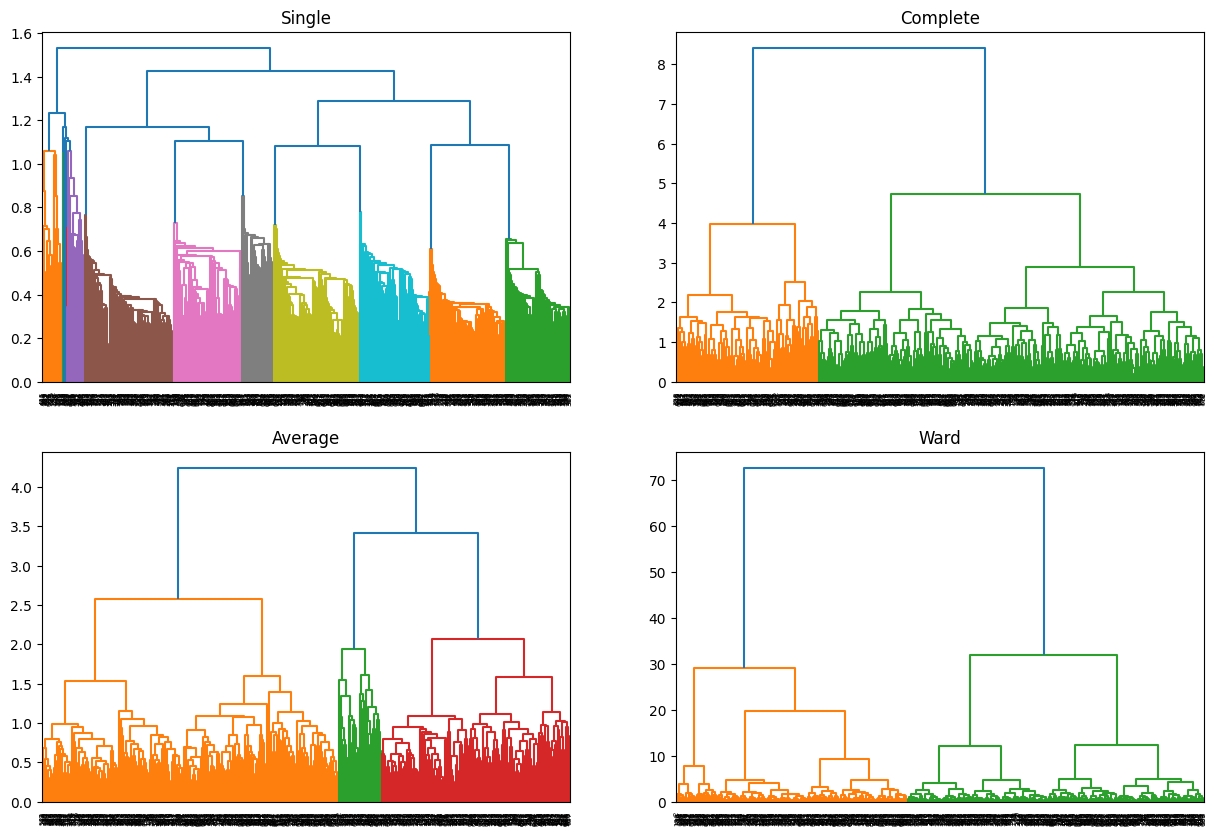

In [ ]:
############# RUN A hierarchical agg clustering on averaging all VARS, V1 ##############


## Plot cluster options
# Remove non-numeric columns (e.g., Participant ID)
df_features = demo_df.drop(columns=['num_id'])  # Adjust column name as needed
df_features = df_features.dropna()
cl.hierarchical_agg_plot(df_features)


In [ ]:
# Agglomerative clustering

# Define the model -- CHANGE based on above fits
agg_clustering = AgglomerativeClustering(n_clusters=7, metric="euclidean", linkage="single")

# Fit model and predict clusters
demo_df["demo_cluster"] = agg_clustering.fit_predict(df_features)

# View cluster assignments

demo_clusters = demo_df.copy()
demo_clusters["demo_cluster"] = demo_df["demo_cluster"]
demo_clusters.value_counts()

# Save DF
demo_clusters.to_csv(os.path.join(brighten_dir, 'demo_clusters.csv'), index=False)
print('Saved demo_clusters to demo_clusters.csv')



Saved demo_clusters to demo_clusters.csv


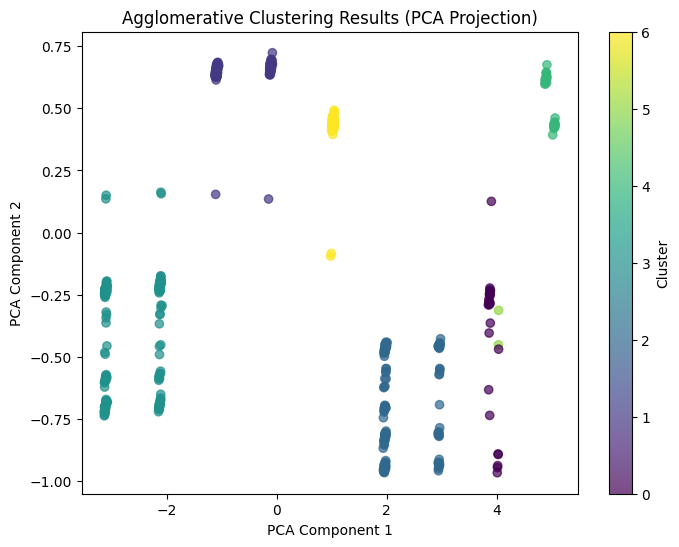

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_features)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=demo_clusters["demo_cluster"], cmap="viridis", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Agglomerative demo_clustering Results (PCA Projection)")
plt.colorbar(label="demo_cluster")
plt.show()


In [ ]:
# Compute the mean of each feature for each cluster
# nonscaled

# Force cols to numeric
for col in demo_clusters.columns:
    demo_clusters[col] = pd.to_numeric(demo_clusters[col], errors='coerce')

# Compute means table
cluster_means = demo_clusters.groupby("demo_cluster").median()

# Clean table
if 'num_id' in cluster_means.columns:
    cluster_means=cluster_means.drop(columns='num_id')
cluster_means = cluster_means.round(0).astype(int)
cluster_means = cluster_means.reset_index()


# Display the DataFrame in Jupyter Notebook
display(cluster_means)


,Cluster,gender,education,working,income_satisfaction,income_lastyear,marital_status,race,age,alc_sum,gad7_sum,phq9_sum_base,mhs_sum,bipolar,scz
0,0,0,3,0,1,5,2,6,11,4,14,16,3,2,0
1,1,0,3,1,3,6,2,6,9,3,11,15,1,0,0
2,2,0,2,1,1,2,0,6,20,3,11,14,0,0,0
3,3,0,3,1,1,5,2,6,8,4,10,14,0,0,0
4,4,0,2,0,3,6,2,6,17,2,16,17,2,2,0
5,5,0,4,0,2,4,0,2,34,8,16,20,3,2,1
6,6,0,2,1,3,6,0,6,19,3,10,12,1,0,0


In [ ]:
from scipy.stats import kruskal

# First remove any have identical values across all clusters
constant_features = [col for col in demo_df.columns if demo_df[col].nunique() == 1]
print("Features with identical values across all clusters:", constant_features)

# Identify and drop features with identical values across clusters
variable_features = [col for col in demo_df.columns if demo_df[col].nunique() > 1]

# Perform Kruskal-Wallis test for each feature
kruskal_results = {
    feature: kruskal(*[demo_df[demo_df['demo_cluster'] == c][feature] for c in demo_df['demo_cluster'].unique()])
    for feature in variable_features
}

# Extract p-values
kruskal_pvalues = {feature: round(result.pvalue, 6) for feature, result in kruskal_results.items()}

# Convert to DataFrame for visualization
kruskal_df = pd.DataFrame.from_dict(kruskal_pvalues, orient='index', columns=['p-value'])

kruskal_df

Features with identical values across all clusters: ['gender', 'working', 'scz']


,p-value
participant_id,0.000832
education,0.002590
income_satisfaction,0.000000
income_lastyear,0.000000
marital_status,0.000000
race,0.000467
age,0.000000
alc_sum,0.000277
gad7_sum,0.005049
phq9_sum_base,0.001240


In [ ]:
demo_clusters['demo_cluster'].value_counts()

for feature in demo_clusters.columns:
    print(feature)
    print(demo_clusters.groupby('demo_cluster')[feature].count())

participant_id
Cluster
0    0
1    0
2    0
3    0
4    0
5    0
6    0
Name: participant_id, dtype: int64
gender
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: gender, dtype: int64
education
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: education, dtype: int64
working
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: working, dtype: int64
income_satisfaction
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: income_satisfaction, dtype: int64
income_lastyear
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: income_lastyear, dtype: int64
marital_status
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: marital_status, dtype: int64
race
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: race, dtype: int64
age
Cluster
0     27
1    186
2    132
3    205
4     27
5      2
6    117
Name: age, dtype: i

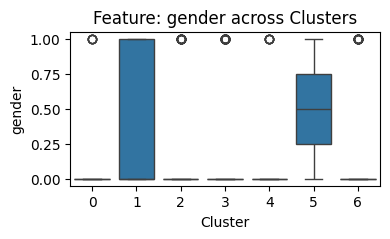

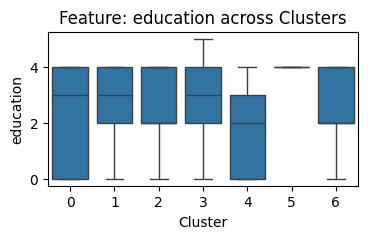

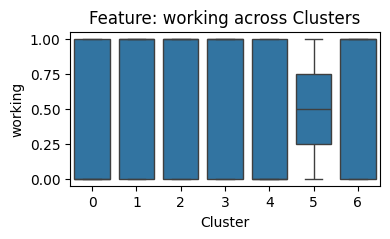

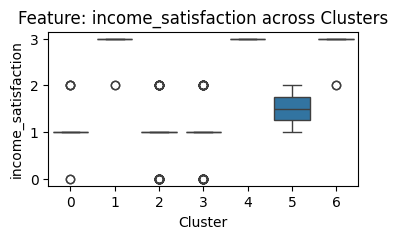

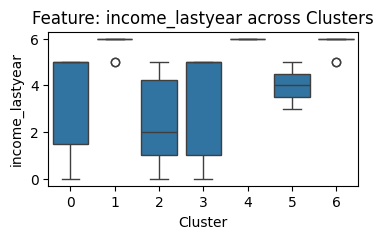

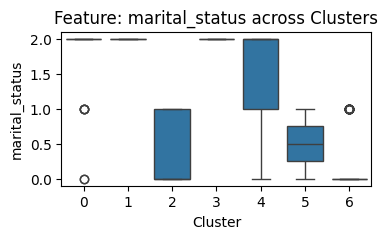

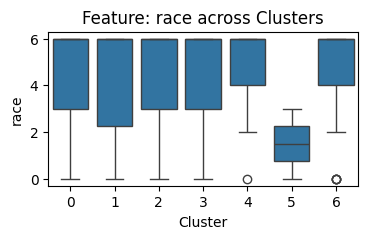

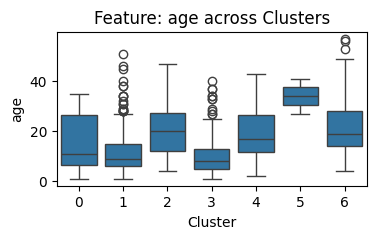

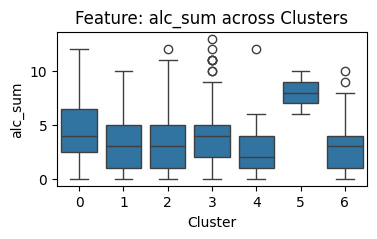

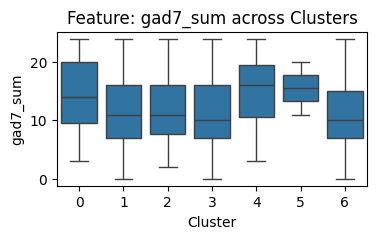

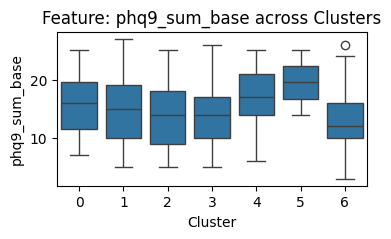

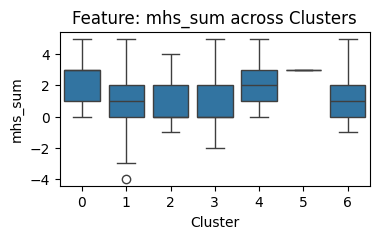

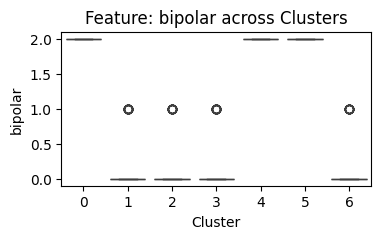

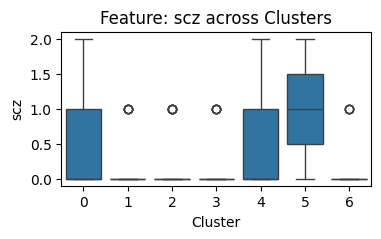

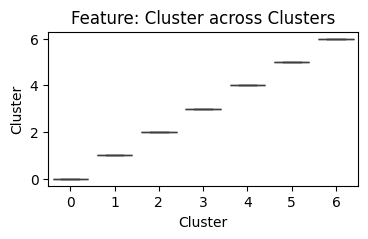

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in [col for col in demo_clusters.columns if col != 'num_id']:  # Check a few features
    plt.figure(figsize=(4, 2))
    sns.boxplot(x="demo_cluster", y=feature, data=demo_clusters)
    plt.title(f"Feature: {feature} across Clusters")
    plt.show()

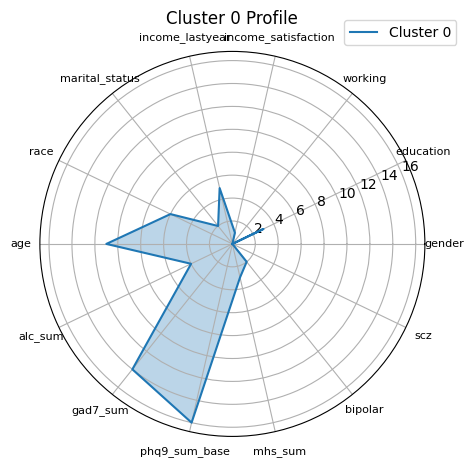

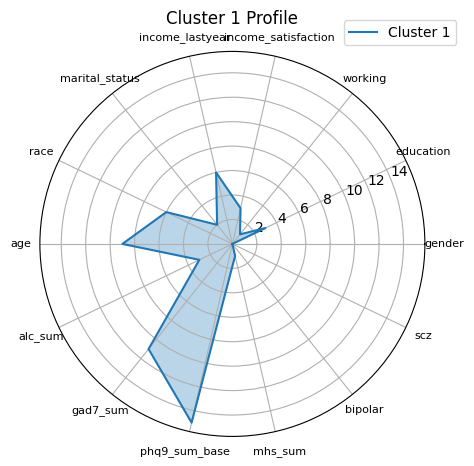

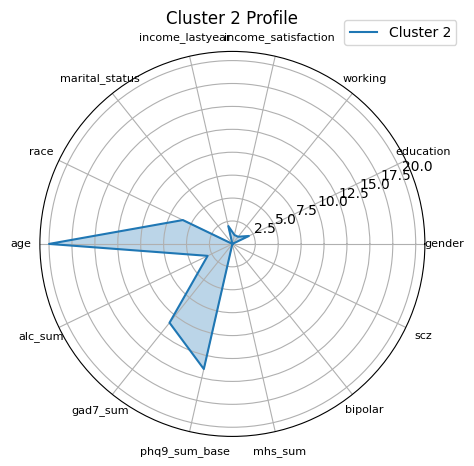

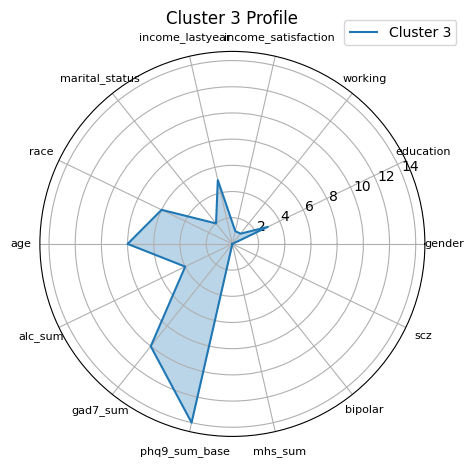

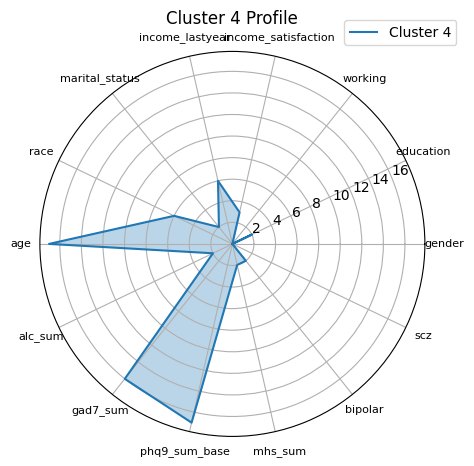

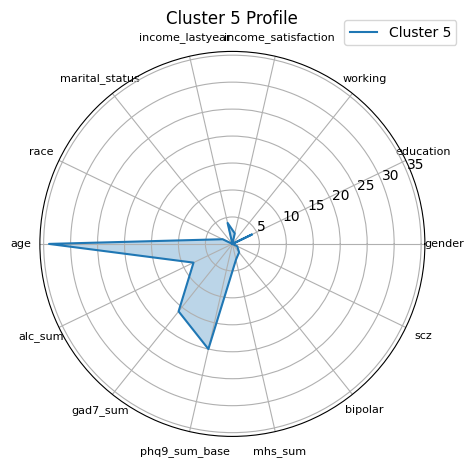

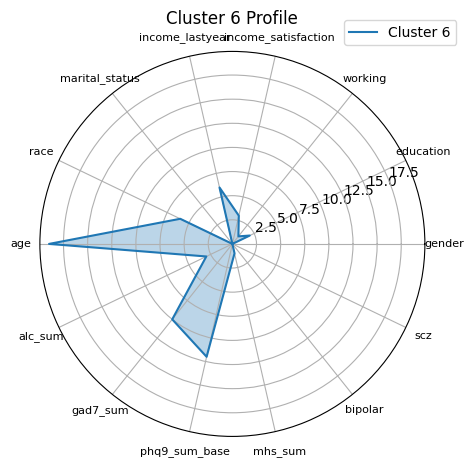

In [ ]:
import numpy as np

# Select key features to visualize
features = cluster_means.columns[1:41]  # Select the first 6 features
num_clusters = demo_clusters['Cluster'].nunique()

# Compute mean values per cluster
cluster_profiles = cluster_means[features].values

# Radar chart setup
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Plot each cluster separately
for i in range(num_clusters):
    values = cluster_profiles[i].tolist()
    values += values[:1]  # Close the circle

    # Create a new figure for each cluster
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

    ax.plot(angles, values, label=f"Cluster {i}")
    ax.fill(angles, values, alpha=0.3)

    # Label each axis
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, fontsize=8, rotation=45)

    # Show the plot
    plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))
    plt.title(f"Cluster {i} Profile")
    plt.show()



In [ ]:

# Restore original category names
cluster_means_categories = pd.DataFrame()
for col, encoder in label_encoders.items():
    cluster_means_categories[col] = encoder.inverse_transform(cluster_means[col].astype(int))

# Select all columns which aren't in columns_to_scale
leftover_cols = list(set(cluster_means.columns.to_list()).difference(cluster_means_categories.columns.to_list()))
cluster_means_categories[leftover_cols] = cluster_means[leftover_cols]
 
display(cluster_means_categories)


,gender,education,working,income_satisfaction,income_lastyear,marital_status,race,age,scz,phq9_sum_base,Cluster,bipolar,gad7_sum,mhs_sum,alc_sum
0,Female,High School,No,Can't make ends meet,"< $20,000",Single,Non-Hispanic White,28.0,0,16,0,2,14,3,4
1,Female,High School,Yes,NaN,NaN,Single,Non-Hispanic White,26.0,0,15,1,0,11,1,3
2,Female,Graduate Degree,Yes,Can't make ends meet,"40,000-60,000",Married/Partner,Non-Hispanic White,37.0,0,14,2,0,11,0,3
3,Female,High School,Yes,Can't make ends meet,"< $20,000",Single,Non-Hispanic White,25.0,0,14,3,0,10,0,4
4,Female,Graduate Degree,No,NaN,NaN,Single,Non-Hispanic White,34.0,0,17,4,2,16,2,2
5,Female,University,No,Have enough to get along,"80,000-100,000",Married/Partner,Asian,51.0,1,20,5,2,16,3,8
6,Female,Graduate Degree,Yes,NaN,NaN,Married/Partner,Non-Hispanic White,36.0,0,12,6,0,10,1,3
